# **Generative Adversarial Network (GAN): The DCGAN Tutorial**

## Download the Dataset

In [1]:
# mount on Google Drive if you want
# from google.colab import drive
# drive.mount('/content/drive')

workspace_dir = '.'

# Download the dataset
!gdown --id 1xShlRva_i7_AC2oMIkxjIKnvfDA6z25h --output "{workspace_dir}/crypko_data.zip"

Downloading...
From: https://drive.google.com/uc?id=1xShlRva_i7_AC2oMIkxjIKnvfDA6z25h
To: /content/crypko_data.zip
452MB [00:05, 89.3MB/s]


In [2]:
# unzip the dataset
!unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## Prepare Data

- Define the Dataset:
  - Since we'll use `torchvision` to store the images, we have to convert the format reading from `cv2` to the format aligning with `torchvision`. That is, from (BGR) to (RGB).
- Define preprocess:
  - Resize the input to (64, 64).
  - Transform the value from (0, 1) to (-1, 1).

In [3]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os

class FaceDataset(Dataset):
  def __init__(self, fnames, transform):
    self.transform = transform
    self.fnames = fnames
    self.num_samples = len(self.fnames)

  
  def __getitem__(self, idx):
    fname = self.fnames[idx]
    img = cv2.imread(fname)
    img = self.BGR2RGB(img) # because "torchvision.utils.save_image" use RGB
    img = self.transform(img)
    return img

  def __len__(self):
    return self.num_samples
  
  def BGR2RGB(self, img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

import glob
import torchvision.transforms as transforms


img_channels = 3

def get_dataset(root):
  fnames = glob.glob(os.path.join(root, '*'))
  # transform all the images
  # resize them to (64, 64)
  # linearly map [0, 1] to [-1, 1]
  transform = transforms.Compose(
      [
       transforms.ToPILImage(),
       transforms.Resize((64, 64)),
       transforms.ToTensor(),
       transforms.Normalize([0.5 for _ in range(img_channels)], [0.5 for _ in range(img_channels)])
      ]
  )
  dataset = FaceDataset(fnames, transform)
  return dataset

## Define Useful Functions
- Make same seed to reproduce.



In [4]:
import random
import torch
import numpy as np

def same_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # for muli-GPU
  np.random.seed(seed) # numpy module
  random.seed(seed) # Python random module
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

## Build the Model

- The `weights_init` function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. **This function is applied to the models immediately after initialization.**

In [5]:
import torch.nn as nn


def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

class Generator(nn.Module):
  """
  input: (N, in_dim)
  output: (N, 3, 64, 64)
  """
  def __init__(self, in_dim, dim=64):
    super(Generator, self).__init__()
    def deconv_bn_relu(in_dim, out_dim):
      return nn.Sequential(
          nn.ConvTranspose2d(
              in_dim,
              out_dim,
              kernel_size=5,
              stride=2,
              padding=2,
              output_padding=1,
              bias=False # for using BatchNorm2d
          ),
          nn.BatchNorm2d(out_dim),
          nn.ReLU()
      )
    self.l1 = nn.Sequential(
        # input size: (N, C​, H​, W​) = (N, in_dim, 1, 1)
        nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False), # output size: (8192)
        nn.BatchNorm1d(dim * 8 * 4 * 4),
        nn.ReLU()
    )

    # No BatchNorm is in the last layer of Generator
    self.l2_5 = nn.Sequential(
        # input size: (N, C​, H​, W​) = (N, dim * 8, 4, 4)
        deconv_bn_relu(dim * 8, dim * 4), # 8*8
        deconv_bn_relu(dim * 4, dim * 2), # 16*16
        deconv_bn_relu(dim * 2, dim),    # 32*32
        nn.ConvTranspose2d(dim, 3, kernel_size=5, stride=2, padding=2, output_padding=1), # 64*64
        nn.Tanh() # scale the output to [-1, 1]
    )
    self.apply(weights_init)

  def forward(self, x):
    y = self.l1(x)
    # input: (N, C​, H​, W​) = (N, 8192) = (N, 512 * 4 * 4)
    y = y.view(y.size(0), -1, 4, 4)
    # output: (N, C​, H​, W​) = (N, dim * 8, 4, 4)
    y = self.l2_5(y)
    return y


  
class Discriminator(nn.Module):
  """
  input: (N, 3, 64, 64)
  output: (N, )
  """
  def __init__(self, in_dim, dim=64):
    super(Discriminator, self).__init__()
    def conv_bn_lrelu(in_dim, out_dim):
      return nn.Sequential(
          nn.Conv2d(in_dim, out_dim, kernel_size=5, stride=2, padding=2),
          nn.BatchNorm2d(out_dim),
          nn.LeakyReLU(0.2)
      )

    # No BatchNorm is in the 1st layer of Discriminator
    self.ls = nn.Sequential(
        # input size: (N, C​, H​, W​) = (N, in_dim, 64, 64)
        nn.Conv2d(in_dim, dim, kernel_size=5, stride=2, padding=2), # 32*32
        nn.LeakyReLU(0.2),
        conv_bn_lrelu(dim, dim * 2),    # 16*16
        conv_bn_lrelu(dim * 2, dim * 4), # 8*8
        conv_bn_lrelu(dim * 4, dim * 8), # 4*4
        # output size: (N, C, H, W) = (N, 1, 4, 4)
        nn.Conv2d(dim * 8, 1, 4),     # 1*1
        nn.Sigmoid()
    )
    self.apply(weights_init)

  def forward(self, x):
    y = self.ls(x)
    y = y.view(-1) # (N, )
    return y

In [6]:
# Inspect the model structure
print(Generator(in_dim=100))
print(Discriminator(in_dim=3))

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2_5): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


## Training
- Set up hyperparameters
- Prepare the Dataloader, model, loss, criterion, and optimizer.

In [7]:
import torch
from torch import optim
from torch.autograd import Variable
import torchvision

# hyperparameters
batch_size = 64
z_dim = 100
lr = 1e-4
n_epoch = 10
save_dir = os.path.join(workspace_dir, 'logs')
os.makedirs(save_dir, exist_ok=True)

# model
G = Generator(in_dim=z_dim).cuda()
D = Discriminator(in_dim=3).cuda()

G.train()
D.train()

# loss criterion
criterion = nn.BCELoss()

# optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

# same seed
same_seed(0)

# dataloader
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


- Print a image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


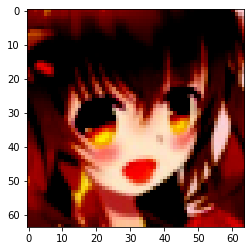

In [8]:
import matplotlib.pyplot as plt
plt.imshow(dataset[10].numpy().transpose(1, 2, 0))

- Initialize a writer for showing data on tensorboard.

In [9]:
# from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard
# writer_real = SummaryWriter(f"logs/real")
# writer_fake = SummaryWriter(f"logs/fake")
# step = 0

- Now, we're going to train the model.
- Save the checkpoints to observe the performance of Generator.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/10] 1115/1115 Loss_D: 0.2553 LossG: 5.3407 | Save some samples to ./logs/Epoch_001.jpg.


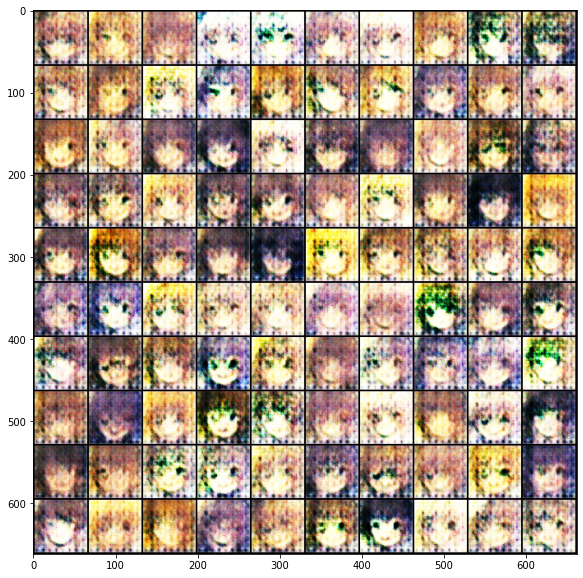

Epoch [2/10] 1115/1115 Loss_D: 0.0829 LossG: 4.6399 | Save some samples to ./logs/Epoch_002.jpg.


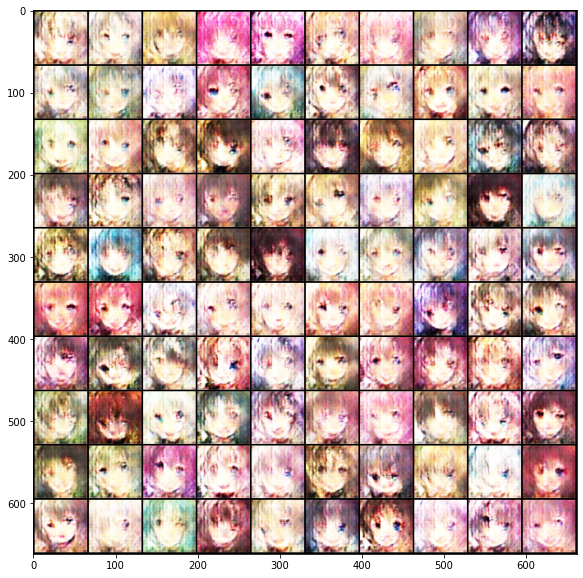

Epoch [3/10] 1115/1115 Loss_D: 0.1749 LossG: 3.7323 | Save some samples to ./logs/Epoch_003.jpg.


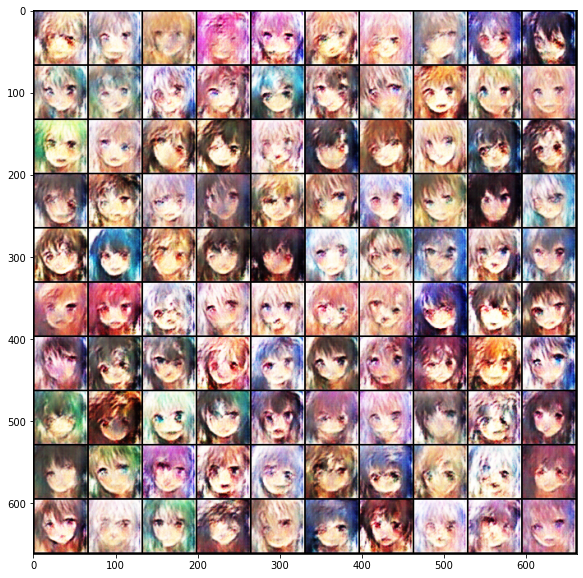

Epoch [4/10] 1115/1115 Loss_D: 0.2763 LossG: 4.6508 | Save some samples to ./logs/Epoch_004.jpg.


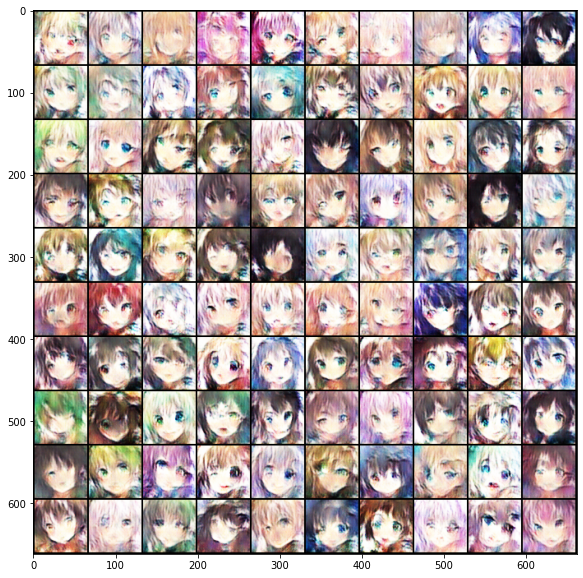

Epoch [5/10] 1115/1115 Loss_D: 0.1947 LossG: 3.0657 | Save some samples to ./logs/Epoch_005.jpg.


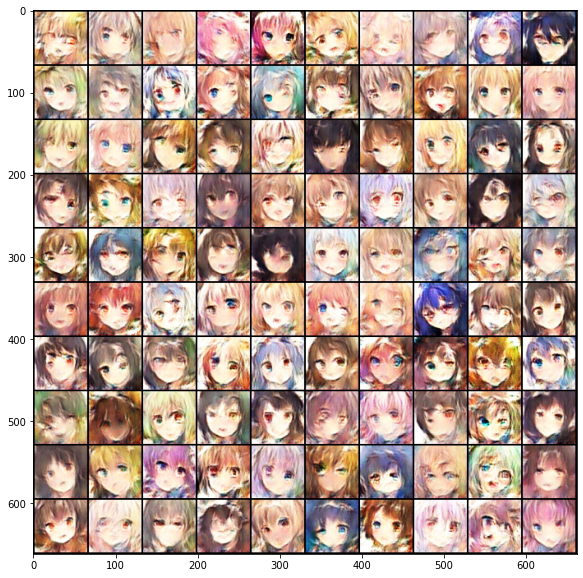

Epoch [6/10] 1115/1115 Loss_D: 0.2594 LossG: 5.5269 | Save some samples to ./logs/Epoch_006.jpg.


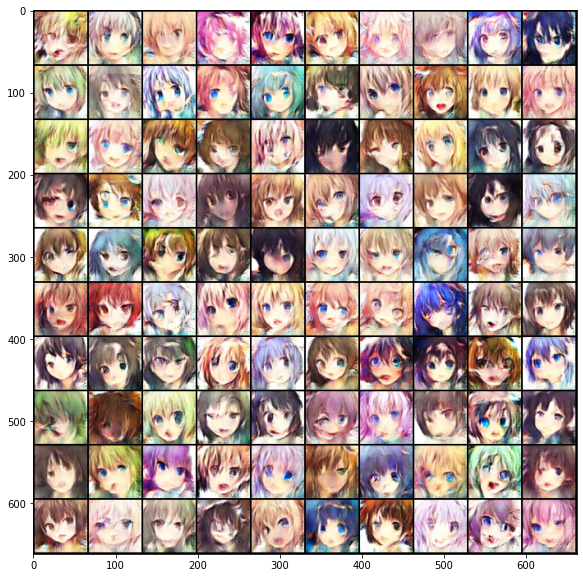

Epoch [7/10] 1115/1115 Loss_D: 0.3492 LossG: 5.5600 | Save some samples to ./logs/Epoch_007.jpg.


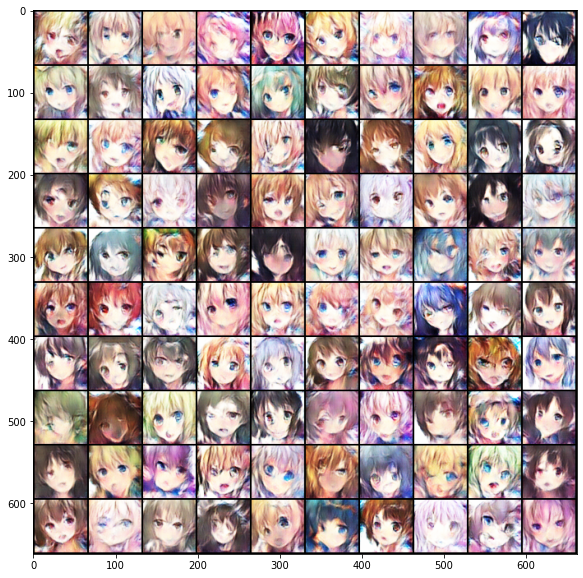

Epoch [8/10] 1115/1115 Loss_D: 0.0918 LossG: 4.9256 | Save some samples to ./logs/Epoch_008.jpg.


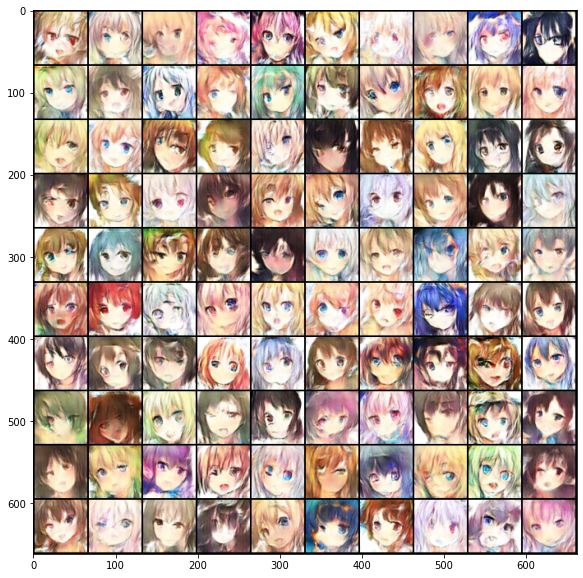

Epoch [9/10] 1115/1115 Loss_D: 0.3424 LossG: 7.3148 | Save some samples to ./logs/Epoch_009.jpg.


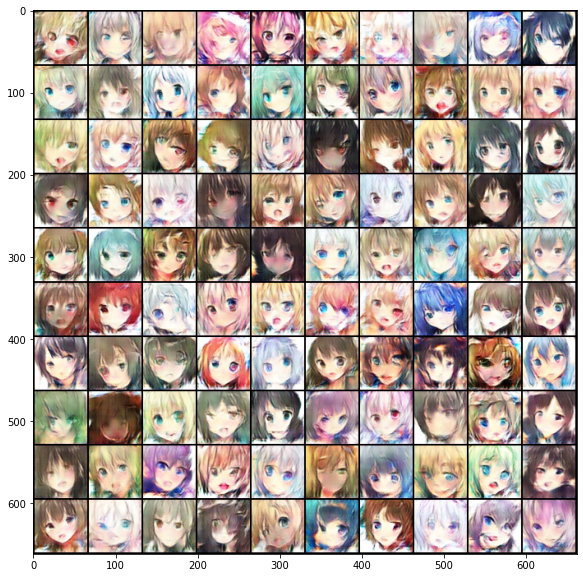

Epoch [10/10] 1115/1115 Loss_D: 0.0954 LossG: 4.7494 | Save some samples to ./logs/Epoch_010.jpg.


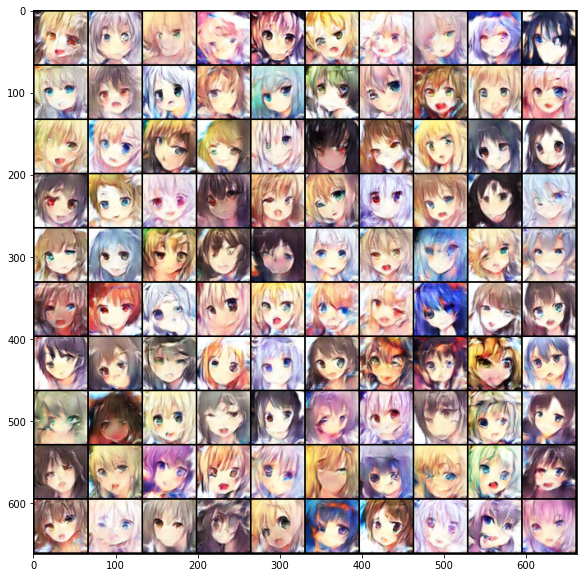

In [10]:
# for logging
z_sample = Variable(torch.randn(100, z_dim)).cuda()

for e, epoch in enumerate(range(n_epoch)):
  for i, data in enumerate(dataloader):
    imgs = data # real images
    imgs = imgs.cuda()

    bs = imgs.size(0) # batch_size
    
    """ Train the Discriminator """
    z = Variable(torch.randn(bs, z_dim)).cuda() # latent vectors
    r_imgs = Variable(imgs).cuda() # real images
    f_imgs = G(z) # fake images

    # label
    r_label = torch.ones((bs)).cuda()
    f_label = torch.zeros((bs)).cuda()

    # discriminator output
    r_logit = D(r_imgs.detach()) # the r_imgs doesn't require gradient
    f_logit = D(f_imgs.detach()) # the f_imgs doesn't require gradient
    
    # compute loss
    r_loss = criterion(r_logit, r_label)
    f_loss = criterion(f_logit, f_label)
    loss_D = (r_loss + f_loss) / 2
    

    # update model
    D.zero_grad()   # zero the gradient to aviod accumulation
    loss_D.backward() # compute the gradient 
    opt_D.step()   # update the gradient

    """ Train the Generator """
    # leaf
    z = Variable(torch.randn(bs, z_dim)).cuda() # latent vectors
    f_imgs = G(z) # produce fake images

    # discriminator
    f_logit = D(f_imgs)

    # compute loss
    loss_G = criterion(f_logit, r_label)

    # update model
    G.zero_grad()     # zero the gradient to aviod accumulation
    loss_G.backward()   # compute the gradient 
    opt_G.step()     # update the gradient

    # log
    print(f'\rEpoch [{epoch+1}/{n_epoch}] {i+1}/{len(dataloader)} Loss_D: {loss_D.item():.4f} LossG: {loss_G.item():.4f}', end='')

    # # store some images for showing the image on tensorboard
    # # you can comment this section if you don't want it
    # if i % 100 == 0:
    #   with torch.no_grad():
    #     fake = G(z_sample).data
    #     # take out (up to) 32 examples
    #     img_grid_real = torchvision.utils.make_grid(
    #         imgs[:32], normalize=True
    #     )
    #     img_grid_fake = torchvision.utils.make_grid(
    #         fake[:32], normalize=True
    #     )

    #     writer_real.add_image("Real", img_grid_real, global_step=step)
    #     writer_fake.add_image("Fake", img_grid_fake, global_step=step)
    #   step += 1

  # track the Generator performance on each epoch based on the "same sample"
  G.eval()
  f_imgs_sample = (G(z_sample).data + 1) / 2.0 # resize to [0, 1]
  filename = os.path.join(save_dir, f'Epoch_{epoch+1:03d}.jpg')
  torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
  print(f' | Save some samples to {filename}.')
  # show generated image
  grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
  plt.figure(figsize=(10, 10))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()
  G.train()

  if (e+1) % 5 == 0:
    torch.save(G.state_dict(), os.path.join(workspace_dir, f'dcgan_g.pth'))
    torch.save(D.state_dict(), os.path.join(workspace_dir, f'dcgan_d.pth'))

- Show the Results on Tensorboard

In [11]:
# %tensorboard --logdir logs
# %tensorboard --logdir=runs

## Inference
- Use the trained Generator to produce images.

In [12]:
import torch
# load the pretrained model
G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(workspace_dir, 'dcgan_g.pth')))
G.eval()
G.cuda()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2_5): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


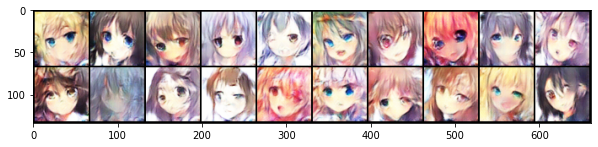

In [13]:
# generate the image and save the result
n_output = 20
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0 # resize to [0, 1]
save_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(workspace_dir, f'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# show image
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()